# Table of Contents

1. **[Background](#Bakground)**
2. **[Set Up](#Set-Up)**\
    a. [Means](#Means) \
    b. [Create an xgcm grid](#Create-an-xgcm-grid)
3. **[Surface Geostrophic Velocity](#surf_geo_velo)** \
    a. [u_s](#u_s) \
    b. [v_s](#vs_calc)
4. **[Geostrophic Shear](#Geostrophic-Shear)** \
    a. [Potential Density](#Potential-density-calculation)\
    b. [Buoyancy](#Buoyancy-Calculation)\
    c. [Calculation of Geostrophic Shear](#Calculation-of-Geostrophic-Shear) \
    d. [Plot of Geostrophic Shear](#Plot-of-Geostrophic-Shear)
5. **[Geostrophic Velocity from Geostrophic Shear](#v_g_from_shear)**\
    a. [Plot of Geostrophic Velocity Calculated from Geostrophic Shear](#v_g_from_shear_plot)
6. **[Tuchen et al Recreation](#tuchen)**\
    a. [11$^{\circ}$S](#11S) \
    b. [10$^{\circ}$N](#10N) \
    c. [Geostrophic V Velocity at Latitudes](#velo_from_shear_lats) \
    d. [V Velocity at Latitudes](#velo_lats) \
    e. [Comparison of Geostrophic Velo & Velo at Latitudes](#comparisons)
7. **[V Volume Transport Through Tropics](#volume_plot)**
8. **[Geostrophic U Velocity at Latitudes](#geouvelo)**

# Background

This notebook covers the following calculations:
- calculation of mean sea surface height, sea surface salinity, zonal velocity, meridional velocity, seawater potential
- use of above means to calculate geostrophic velocity, geostrophic shear, and geostrophic velocity from geostrophic shear
- these calculations use code from [Geostrophic_Current_Velo_1958](https://vortex.geos.tamu.edu/user/kuyeda/notebooks/Geostrophic_Current_Velo_1958.ipynb#Plot-Geostrophic-Component-of-Velocity-of-Surface-Current). Full explanations for calculations can be found there.

## Set Up

In [1]:
import xarray as xr
import xgcm
from xgcm import Grid
import numpy as np
import warnings
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(8,5)

In [2]:
%cd /vortex1/OM4_output/new_run
!ls

/vortex1/OM4_output/new_run
19580101.ocean_annual.nc	 19590101.ocean_annual_rho2.nc
19580101.ocean_annual_rho2.nc	 19590101.ocean_annual_z.nc
19580101.ocean_annual_z.nc	 19590101.ocean_daily.nc
19580101.ocean_daily.nc		 19590101.ocean_month.nc
19580101.ocean_month.nc		 19590101.ocean_month_rho2.nc
19580101.ocean_month_rho2.nc	 19590101.ocean_month_snap.nc
19580101.ocean_month_snap.nc	 19590101.ocean_month_z.nc
19580101.ocean_month_z.nc	 19590101.ocean_scalar_annual.nc
19580101.ocean_scalar_annual.nc  19590101.ocean_scalar_month.nc
19580101.ocean_scalar_month.nc	 19590101.ocean_static.nc
19580101.ocean_static.nc	 basin_codes.nc
19590101.ocean_annual.nc


In [3]:
static=xr.open_dataset('/vortex1/OM4_output/new_run/19590101.ocean_static.nc',decode_times=False)
#static
# contains static.Coriolis = coriolis parameter
# contains static.areacello_cu and static.areacello_cv = ocean grid cell area 

In [4]:
ds=xr.open_dataset('/vortex1/OM4_output/new_run/19590101.ocean_month.nc',decode_times=False)
#ds
# contains ds.zos = sea surface height above geoid
# contains ds.so = sea water salinity (psu)
# conains ds.pso= sea water pressure at sea water surface

In [5]:
ds1=xr.open_dataset('/vortex1/OM4_output/new_run/19590101.ocean_month_z.nc',decode_times=False)
#ds1
# contains ds1.uo & ds1.vo = zonal & meridional sea surface velocities
# contains thetao = seawater potential temperature (degC)

## Create an xgcm grid

In [6]:
grid= Grid(ds1, coords={'X':{'center':'xh','outer':'xq'},'Y':{'center':'yh','outer':'yq'}, 'Z':{'center':'z_l','outer':'z_i'}},periodic=['X'])

In [7]:
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary=None):
  * center   z_l --> outer
  * outer    z_i --> center

## Means
Take means of ```ds.zos``` (sea surface height)and ```ds.so``` (sea surface salinity), ```ds1.uo```, ```ds1.vo```, ```ds1.thetao``` over time

In [8]:
zos_mean=ds.zos.mean(dim='time')
so_mean=ds1.so.mean(dim='time')
pso_mean=ds.pso.mean(dim='time')
uo_mean=ds1.uo.mean(dim='time')
vo_mean=ds1.vo.mean(dim='time')
thetao_mean=ds1.thetao.mean(dim='time')

# Geostrophic Velocity at Surface ($u_s$,$v_s$)
<a name="surf_geo_velo"></a>

# $u_s$ geostrophic velocity at surface
<a name="u_s_velo"></a>
- we eventually want to get the geostrophic velocity coordinates to match the original uo coordinates (yh,xq). 
- So we need to interpolate the data as follows:
    - Coriolis from (yq,xq) to (yh,xq)
    - ds.zos from (yh,xh) to (yq,xq)
    - static.dxCu from (yh,xh) to (yq,xq)

In [9]:
Cor_interp=grid.interp(static.Coriolis,axis='Y')
zos_interp=grid.interp(zos_mean,axis=['X','Y'])
dxCu_interp=grid.interp(static.dxCu,axis='Y')

## Calculation of $u_s$ geostrophic velocity at surface
<a name="u_s"></a>

In [10]:
u_s=(-9.8/Cor_interp) * (grid.diff((zos_interp),'Y',boundary='fill')) / static.dyCu
#u_s

We plot the geostrophic $u_s$ velocity but eliminate the middle $6^\circ$ by the equator (-3S to 3N) because the Coriolis parameter $f$ is very small there (wind does not rotate at the equator). So, when we divide by $f$ in the geostrophic velocity equation, it will blow up the geostrophic velocity, which isn't accurate. Also, there isn't a lot of geostrophy at the equator anyways.

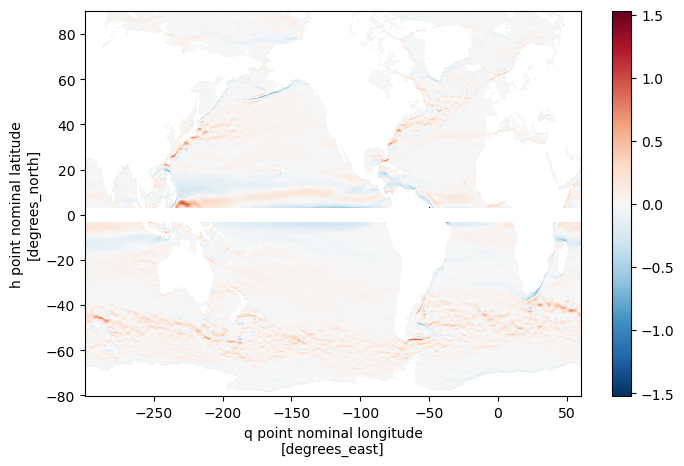

In [11]:
u_s.where((u_s.yh>3) | (u_s.yh<-3)).plot() #,vmin=-1.5,vmax=1.5,cmap='RdBu_r')

# $v_s$ geostrophic velocity at surface
<a name="vs_calc"></a>
- we eventually want to get the geostrophic velocity coordinates to match the original vo coordinates (yq,xh). 
- So we need to interpolate the data as follows:
    - Coriolis from (yq,xq) to (yq,xh)
    - ds.zos from (yh,xh) to (yq,xq)
    - dyCv from (yq,xh) to (yq,xq)

In [12]:
Cor_interp2=grid.interp(static.Coriolis,axis="X")
zos_interp2=grid.interp(zos_mean,axis=["X","Y"])
dyCv_interp2=grid.interp(static.dyCv,axis="X")

## Calculation of geostrophic $v_s$ velocity at surface
<a name="vs"></a>

In [13]:
v_s=(9.8/Cor_interp2) * (grid.diff((zos_interp2),'X',boundary='fill')) / static.dxCv

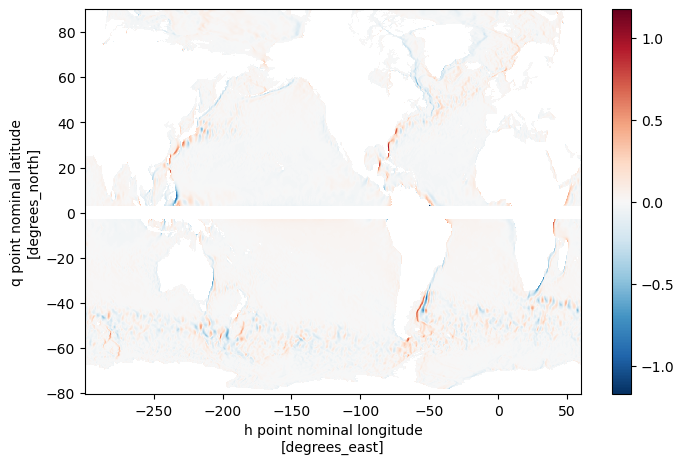

In [14]:
v_s.where((v_s.yq > 3) | (v_s.yq<-3)).plot()

# Geostrophic Shear
- change in geostrophic velocity wrt z (aka vertical gradient)

## Potential density calculation 
- Fucntion for potential density is taken from an equation of state. The paper referenced in the commented out code is ["An Equation of State for use in Ocean Models: Eckart's Formula Revisted"](https://journals.ametsoc.org/view/journals/atot/14/3/1520-0426_1997_014_0735_aeosfu_2_0_co_2.xml) 

In [15]:
def pdens(S,theta):

    # --- Define constants (Table 1 Column 4, Wright 1997, J. Ocean Tech.)---
    a0 = 7.057924e-4
    a1 = 3.480336e-7
    a2 = -1.112733e-7

    b0 = 5.790749e8
    b1 = 3.516535e6
    b2 = -4.002714e4
    b3 = 2.084372e2
    b4 = 5.944068e5
    b5 = -9.643486e3

    c0 = 1.704853e5
    c1 = 7.904722e2
    c2 = -7.984422
    c3 = 5.140652e-2
    c4 = -2.302158e2
    c5 = -3.079464

    # To compute potential density keep pressure p = 100 kpa
    # S in standard salinity units psu, theta in DegC, p in pascals

    p = 200000.
    alpha0 = a0 + a1*theta + a2*S
    p0 = b0 + b1*theta + b2*theta**2 + b3*theta**3 + b4*S + b5*theta*S
    lambd = c0 + c1*theta + c2*theta**2 + c3*theta**3 + c4*S + c5*theta*S

    pot_dens = (p + p0)/(lambd + alpha0*(p + p0))

    return pot_dens

In [16]:
pt=xr.apply_ufunc(pdens,so_mean,thetao_mean,
                 dask='parallelized',
                output_dtypes=[pso_mean.dtype])
#print(pt)

In [57]:
# plan view of potential density
'''
fig=plt.figure(figsize=[15,7])
pt.isel(z_l=0).plot(vmin=1020,vmax=1030,cmap='RdBu_r')
'''

"\nfig=plt.figure(figsize=[15,7])\npt.isel(z_l=0).plot(vmin=1020,vmax=1030,cmap='RdBu_r')\n"

In [58]:
# side view of potential density
'''
fig=plt.figure(figsize=[15,7])
pt.sel(yh=10,method='nearest').plot(vmin=1020,vmax=1030,cmap='RdBu_r')
plt.gca().invert_yaxis()
plt.xlim(-60,0)
'''

"\nfig=plt.figure(figsize=[15,7])\npt.sel(yh=10,method='nearest').plot(vmin=1020,vmax=1030,cmap='RdBu_r')\nplt.gca().invert_yaxis()\nplt.xlim(-60,0)\n"

## Buoyancy Calculation

\begin{equation}
b=-g \frac{\rho \prime}{\rho_0}
\end{equation}

where $g$ is the acceleration due to gravity, $\rho \prime$ is the potential density, and $\rho_0$ is the reference density 


In [19]:
rho_ref = 1035 #1035.
anom_density = pt - rho_ref
#anom_density.isel(time=0,z_l=0).plot()

In [20]:
g = 9.81
buoyancy = -g * anom_density / rho_ref
#buoyancy

## Calculation of Geostrophic Shear
We will use the following equations to calculate geostrophic shear:


\begin{align}
    &\frac{\partial u_s}{\partial z} = \frac{\partial \rho \prime}{\partial y} & and& & \frac{\partial v_s}{\partial z} = \frac{\partial \rho \prime}{\partial y}
\end{align}


where $u_s$ and $v_s$ are geostrophic velocity in the $u$ and $v$ directions, and $\rho \prime$ is the anomaly density between the potential density and a reference density of $1035 \, kg/m^2$. 

> - Note: calculating anomaly density (versus just looking at regular density) does not really matter because we are taking the derivative of a constant either way...

### We must interpolate the Coriolis parameter from (yq,xq) to (yh,xh) to match the other variables
<a name="cor"></a>

In [21]:
f_U=grid.interp(static.Coriolis,axis='Y',boundary='fill')
f_V=grid.interp(static.Coriolis,axis='X',boundary='fill')
#Cor_interp3

Compute density gradients in (x,y) direction. We need to first interpolate the static.d_C_ and static.areacello_c_in order to match the coordinates of anom_density. 
- static.dyCu from (yh,xq) to (yh,xh)
- static.dxCv from (yq,xh) to (yh,xh)

In [22]:
dyCu_interp2=grid.interp(static.dyCu,'X',boundary='fill')
dxCv_interp2=grid.interp(static.dxCv,'Y',boundary='fill')

In [23]:
ddens_dx=grid.diff((anom_density),'X',boundary='fill')/static.dxCu
ddens_dy=grid.diff((anom_density),'Y',boundary='fill')/static.dyCv

For troubleshooting: we looked at density anomaly because geostrophic shear is calculated from $\frac{\partial \rho}{\partial x}$ and $\frac{\partial \rho}{\partial y}$

>- In this graph, we see that by -30 close to the surface, the anomaly density is greater and slightly curved. This implies that in this area, the denisty is lower than the rest of the ocean. Therefore, when calculating shear and taking $\frac{\partial \rho}{\partial z}$, the derivative should be positive because $\rho$ is increasing in that area. We want to check this with the same transect section but showing shear instead of $\rho$.  

In [59]:
# transect of density anomaly
'''
anom_density.sel(yh=-11,method='nearest').plot(vmin=-9)
plt.gca().invert_yaxis()
plt.xlim(-60,0)
'''

"\nanom_density.sel(yh=-11,method='nearest').plot(vmin=-9)\nplt.gca().invert_yaxis()\nplt.xlim(-60,0)\n"

In [25]:
#anom_density.diff('xh').sel(yh=-11,method='nearest').plot()
#plt.gca().invert_yaxis()
#plt.xlim(-60,0)

In [26]:
#ddens_dy=grid.diff((anom_density),'X',boundary='fill').sel(yh=-11,method='nearest').plot(vmin=-1,vmax=1,cmap='RdBu_r')
#plt.gca().invert_yaxis()
#plt.xlim(-60,0)

In [60]:
#cross section of d rho / dx 
'''
ddens_dx_cross=ddens_dx.sel(yh='-11',method='nearest')

ddens_dx_cross.plot(levels=np.arange(-0.0000005,0.0000005,0.0000001),cmap='RdBu_r')
plt.gca().invert_yaxis()
plt.xlim(-60,0)
'''

"\nddens_dx_cross=ddens_dx.sel(yh='-11',method='nearest')\n\nddens_dx_cross.plot(levels=np.arange(-0.0000005,0.0000005,0.0000001),cmap='RdBu_r')\nplt.gca().invert_yaxis()\nplt.xlim(-60,0)\n"

In [28]:
# why do we do this step? for the units
dz_ug =   ddens_dy * g / (f_V * rho_ref)
dz_vg = - ddens_dx * g / (f_U * rho_ref)

## Plot of Geostrophic Shear

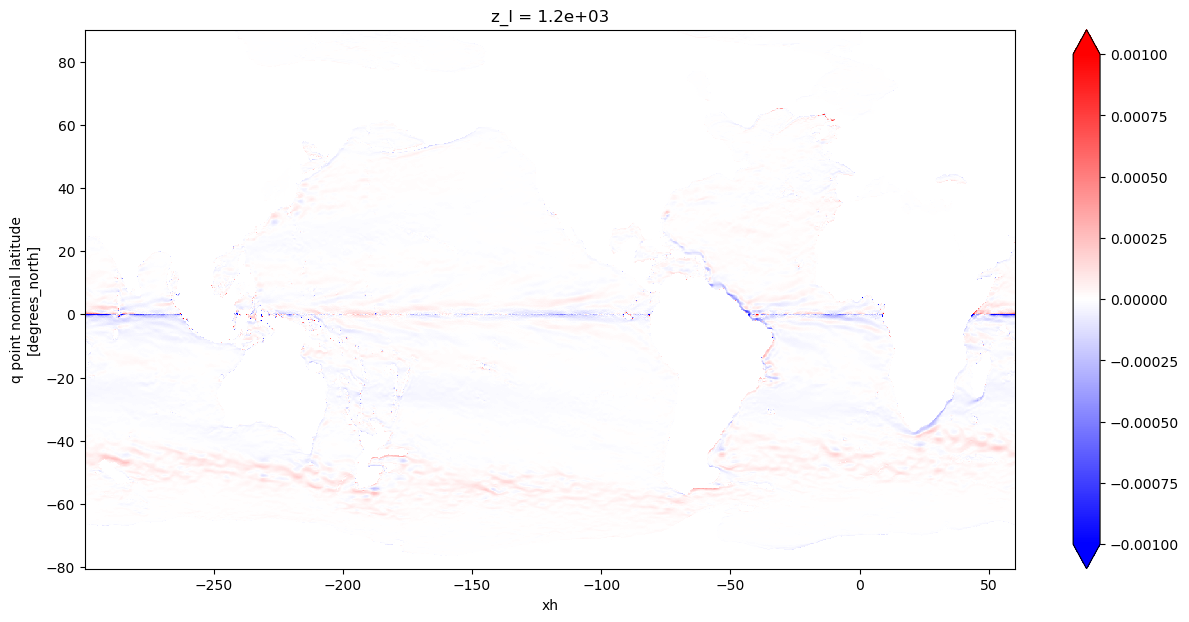

In [29]:
# Geostrophic Shear plot (u)
tmp_u = dz_ug.isel({'z_l': slice(20,21)})

fig = plt.figure(figsize=(15,7))
tmp_u.plot(cmap = 'bwr',vmin = -.001, vmax = 0.001) #cmap=bwr

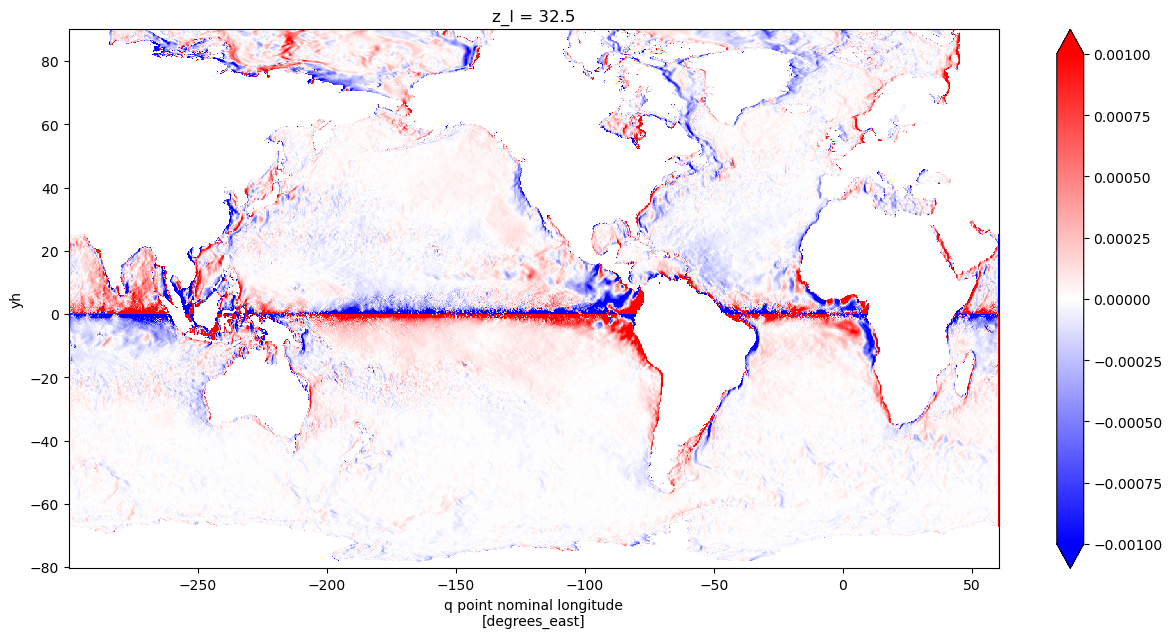

In [30]:
# Geostrophic Shear plot (v)
tmp_v = dz_vg.isel({'z_l': slice(3,4)})

fig = plt.figure(figsize=(15,7))
tmp_v.plot(cmap = 'bwr', vmin = -.001, vmax = 0.001) #cmap=bwr

# Calculation of geostrophic velocity for all depths from geostrophic shear
<a name="v_g_from_shear"></a>

## Recalculation of geostrophic shear accounting for this change
(remove f at equator because it will blow up values)

In [31]:
f_U2=f_U.where((f_U>0) | (f_U < 0))
f_V2=f_V.where((f_V>0) | (f_V < 0))

In [32]:
# why do we do this step? We need to convert our units back
dz_ug2 =   ddens_dy * g / (f_V2 * rho_ref)
dz_vg2 = - ddens_dx * g / (f_U2 * rho_ref)

## Integration of geostrophic shear

In [33]:
dz=grid.diff(ds1.z_i,axis='Z')
indef_int_v=(dz_vg2* dz).cumsum('z_l',skipna=False)
indef_int_u=(dz_ug2* dz).cumsum('z_l',skipna=False)
#indef_int

## Addition of constant C

In [34]:
#print(v_s_excl.coords)
#print(indef_int_v.coords)
v_s_interp=grid.interp(v_s,axis=['X','Y'],boundary='fill')

#print(u_s_excl.coords)
#print(indef_int_u.coords)
u_s_interp=grid.interp(u_s,axis=['X','Y'],boundary='fill')

/home/jupyter-kuyeda/.conda/envs/tropical_project/lib/python3.9/site-packages/xgcm/gridops.py:78: RuntimeWarning: invalid value encountered in add
  return (a[..., :-1] + a[..., 1:]) / 2.0


## Calculation of equation for $v_g$

In [35]:
velo_from_shear_v=-indef_int_v + v_s_interp + indef_int_v.isel(z_l=0)
#velo_from_shear.max()
velo_from_shear_u=-indef_int_u + u_s_interp + indef_int_u.isel(z_l=0)

## Plan view of shear of indefinite integral & velocity at surface for v
- allows us to compare the ___

In [37]:
indef_int_v_plan=(dz_vg2* dz).sum('z_l')

In [66]:
'''
fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(10,15))
indef_int_v_plan.plot(ax=ax[0],vmin=-1,vmax=1,cmap='RdBu_r')
v_s.where((v_s.yq > 3) | (v_s.yq<-3)).plot(ax=ax[1])
ax[0].set_xlim(-60,0)
ax[1].set_xlim(-60,0)
'''

"\nfig,ax=plt.subplots(ncols=1,nrows=2,figsize=(10,15))\nindef_int_v_plan.plot(ax=ax[0],vmin=-1,vmax=1,cmap='RdBu_r')\nv_s.where((v_s.yq > 3) | (v_s.yq<-3)).plot(ax=ax[1])\nax[0].set_xlim(-60,0)\nax[1].set_xlim(-60,0)\n"

## Plot of geostrophic $v_g$ velocity calculated from geostrophic shear
<a name="v_g_from_shear_plot"></a>

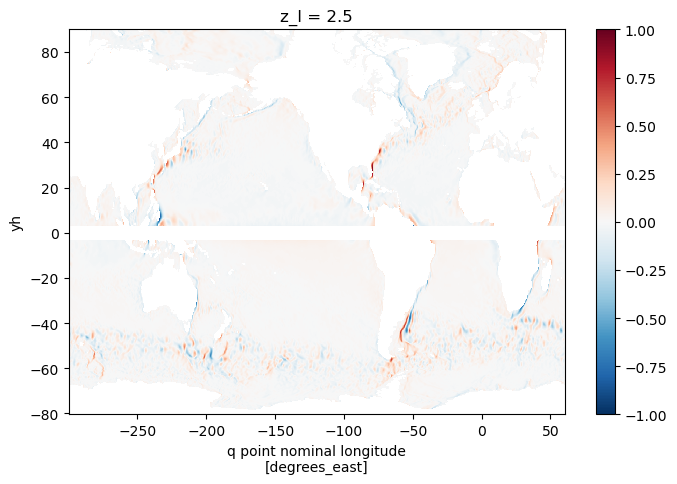

In [39]:
a=velo_from_shear_v.isel(z_l=0).where((velo_from_shear_v.yh > 3) | (velo_from_shear_v.yh < -3))
a.plot(cmap='RdBu_r',vmin=-1,vmax=1)

## Attempt to recreate [Tuchen et al graphs](https://doi.org/10.1029/2021JC018115)

- depth vs longitude of meridional geostrophic flow at the 11S and 10N. 
<a name="tuchen"></a>

In [65]:
#shear
'''
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(15,7))
thing=dz_vg.sel(yh=-11,method="nearest")#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))
thing.plot(x='xq',y='z_l',cmap='RdBu_r',vmin=-0.001,vmax=0.001)
#ax.set_xlim(-40,10)
#ax.set_ylim(0,1500)
plt.gca().invert_yaxis()
'''

'\nfig,ax=plt.subplots(ncols=1,nrows=1,figsize=(15,7))\nthing=dz_vg.sel(yh=-11,method="nearest")#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))\nthing.plot(x=\'xq\',y=\'z_l\',cmap=\'RdBu_r\',vmin=-0.001,vmax=0.001)\n#ax.set_xlim(-40,10)\n#ax.set_ylim(0,1500)\nplt.gca().invert_yaxis()\n'

## 11S

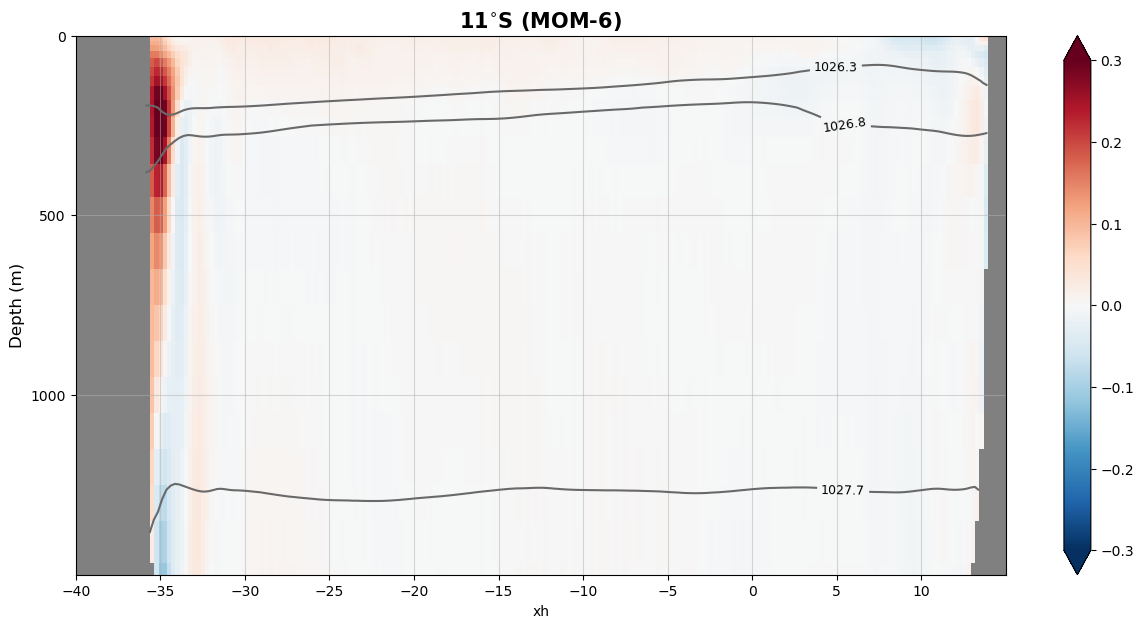

In [67]:
# at 11S
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(15,7))
thing=velo_from_shear_v.sel(yh=-11,method="nearest")#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))
thing.plot(x='xq',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

rho_levels=pt.sel(yh=-11,method='nearest').plot.contour(levels=[1026.3,1026.8,1027.7],colors='dimgray')
manual_locations=[(5,100),(5,325),(5,1400)]
cb=ax.clabel(rho_levels,manual=manual_locations,inline_spacing=-18,fontsize=9,colors='k')#,fmt='%1.0f')

ax.set_facecolor('gray')
ax.set_xlim(-40,15)
ax.set_ylabel('Depth (m)',fontsize=12)
ax.set_ylim(0,1500)
ax.set_yticks(np.arange(0,1500,500))
ax.set_xticks(np.arange(-40,15,5))
ax.grid(alpha=0.5)
ax.set_title('11$^{\circ}$S (MOM-6)',weight='bold',fontsize=15)
plt.gca().invert_yaxis()

In [42]:
# at 11S
#fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(15,7))
#thing=velo_from_shear_v.sel(yh=-11,z_l=0,method="nearest")#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))
#thing.plot()
#ax.set_xlim(-40,10)
#ax.set_ylim(0,1500)
#plt.gca().invert_yaxis()

## 10N

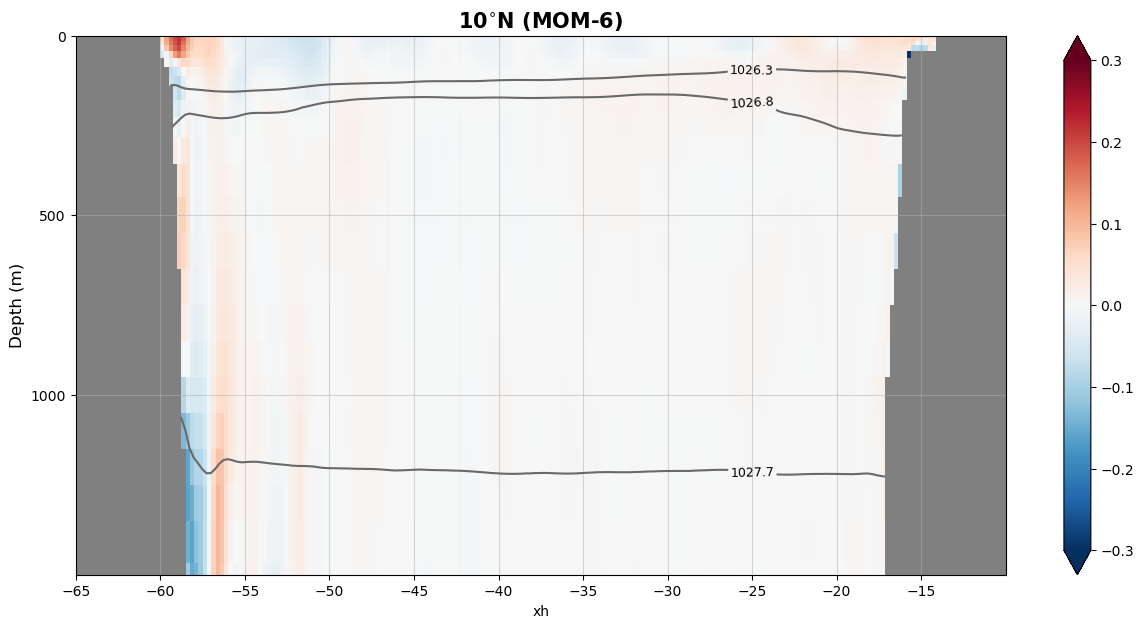

In [43]:
# at 10N
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(15,7))
thing=velo_from_shear_v.sel(yh=10,method="nearest")#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))
thing.plot(x='xq',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)
ax.set_xlim(-60,10)
#ax.set_ylim(0,1500)
plt.gca().invert_yaxis()

rho_levels=pt.sel(yh=10,method='nearest').plot.contour(levels=[1026.3,1026.8,1027.7],colors='dimgray')
manual_locations=[(-25,150),(-25,250,),(-25,1300)]
cb=ax.clabel(rho_levels,manual=manual_locations,inline_spacing=-3,fontsize=9,colors='k')#,fmt='%1.0f')


ax.set_facecolor('grey')
ax.set_xlim(-65,-10)
ax.set_ylabel('Depth (m)',fontsize=12)
ax.set_ylim(0,1500)
ax.set_title('10$^{\circ}$N (MOM-6)',weight='bold',fontsize=15)
ax.set_yticks(np.arange(0,1500,500))
ax.set_xticks(np.arange(-65,-10,5))
ax.grid(alpha=0.5)
plt.gca().invert_yaxis()

## Velo from Geostrophic Shear at 5S, 0, 5N
<a name="velo_from_shear_lats"></a>

Text(0.5, 0.98, 'Geostrophic V Velocity in Tropics region')

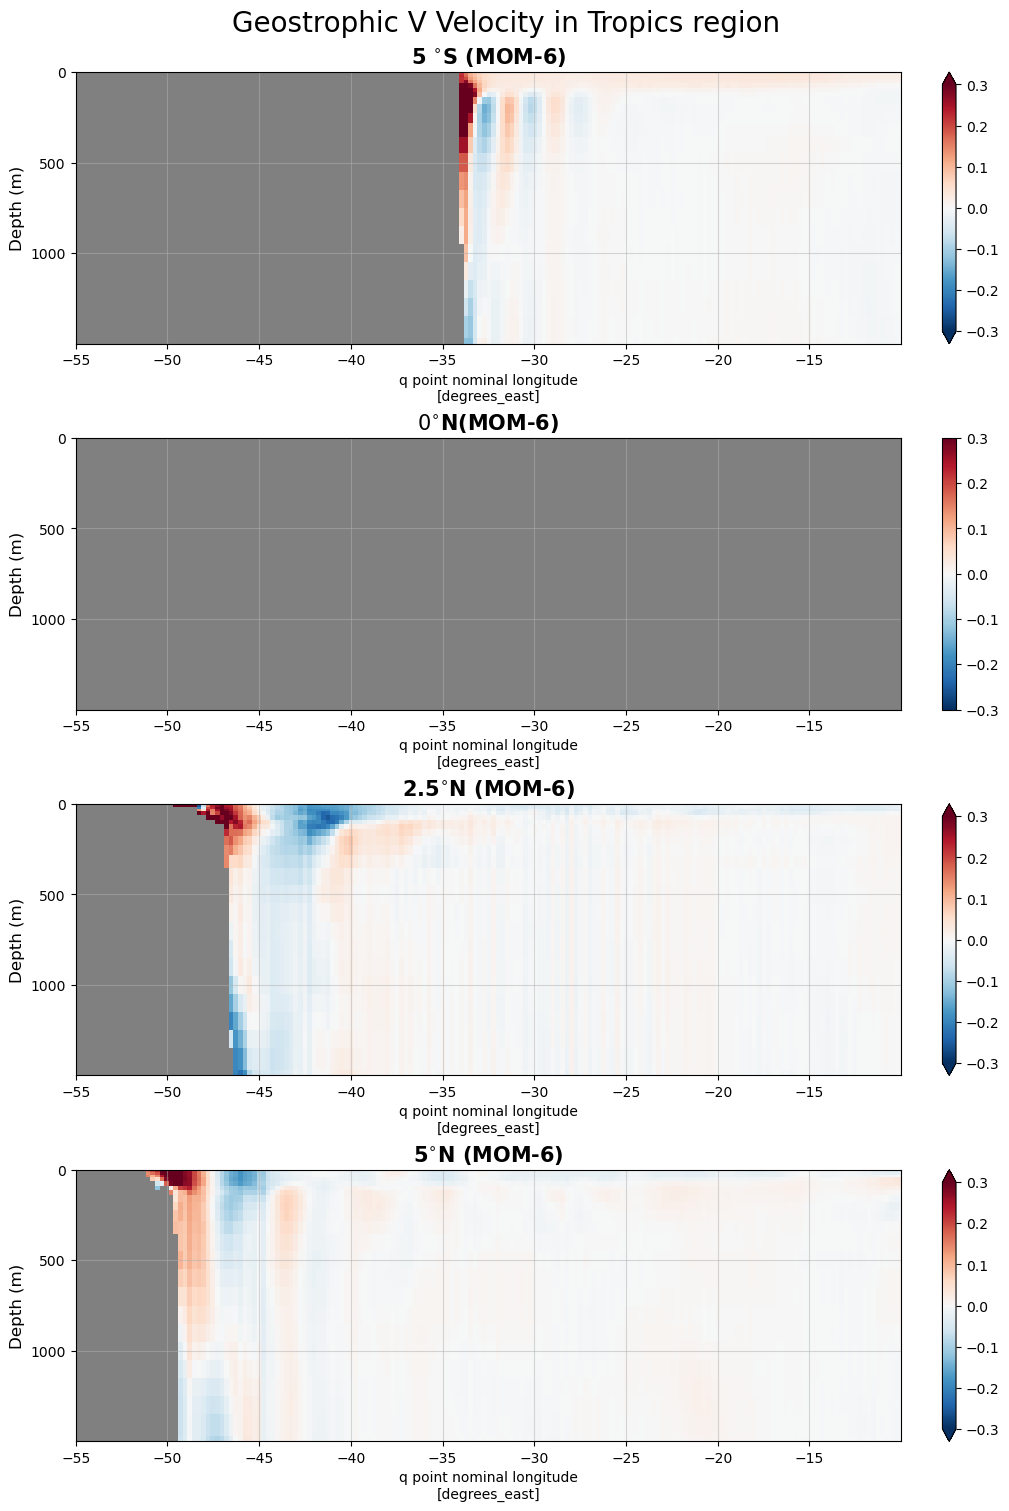

In [68]:
fig,ax=plt.subplots(nrows=4,ncols=1,constrained_layout=True,figsize=(10,15))

vg_5S=velo_from_shear_v.sel(yh=-5,method="nearest")#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))
vg_5S.plot(ax=ax[0],x='xq',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

vg_0=velo_from_shear_v.sel(yh=0,method='nearest')
vg_0.plot(ax=ax[1],x='xq',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

vg_25=velo_from_shear_v.sel(yh=2.5,method="nearest")
vg_25.plot(ax=ax[2],x='xq',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)


vg_5N=velo_from_shear_v.sel(yh=5,method="nearest")
vg_5N.plot(ax=ax[3],x='xq',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

for i in range(0,4):
    ax[i].set_facecolor('grey')
    ax[i].set_xlim(-55,-10)
    ax[i].set_ylabel('Depth (m)',fontsize=12)
    ax[i].set_ylim(0,1500)
    ax[i].set_yticks(np.arange(0,1500,500))
    ax[i].set_xticks(np.arange(-55,-10,5))
    ax[i].grid(alpha=0.5)
    ax[i].invert_yaxis()

ax[0].set_title('5 $^{\circ}$S (MOM-6)',weight='bold',fontsize=15)    
ax[1].set_title('$0^{\circ}$N(MOM-6)',weight='bold',fontsize=15)
ax[2].set_title('2.5$^{\circ}$N (MOM-6)',weight='bold',fontsize=15)
ax[3].set_title('5$^{\circ}$N (MOM-6)',weight='bold',fontsize=15)
fig.suptitle('Geostrophic V Velocity in Tropics region',fontsize=20)

## Meridional Velocity at 5S, 0, 5N
<a name="velo_lats"></a>

Text(0.5, 0.98, 'Meridional Velocity in Tropics Region')

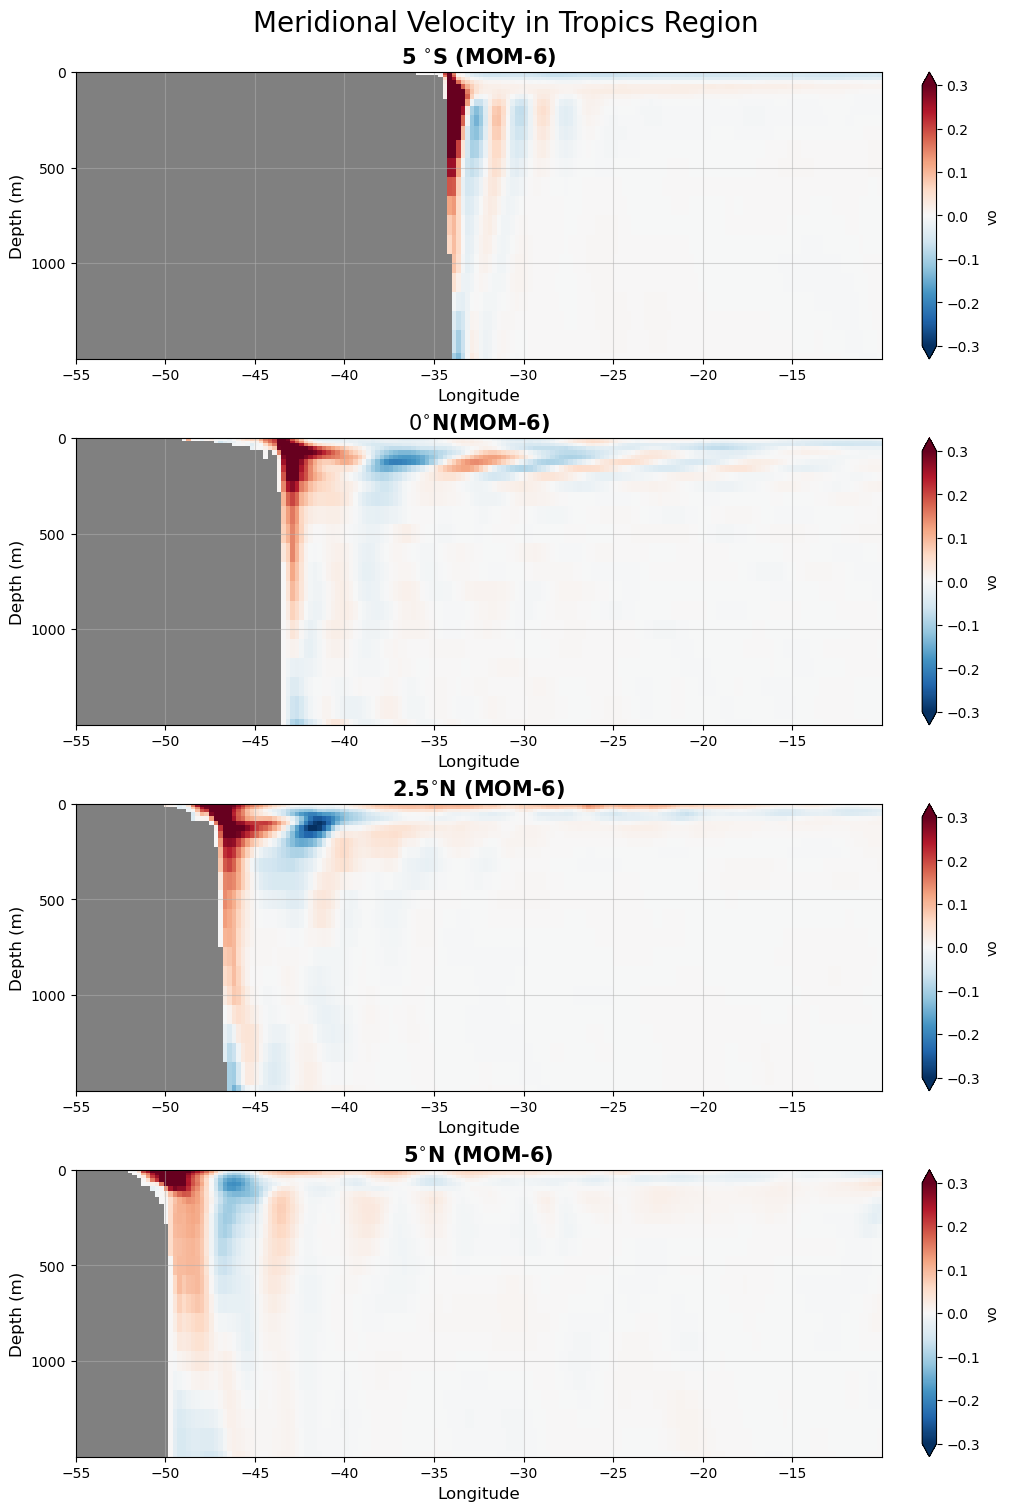

In [45]:
fig,ax=plt.subplots(nrows=4,ncols=1,constrained_layout=True,figsize=(10,15))

v_5S=vo_mean.sel(yq=-5,method="nearest")#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))
v_5S.plot(ax=ax[0],x='xh',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

v_0=vo_mean.sel(yq=0,method="nearest")
v_0.plot(ax=ax[1],x='xh',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

v_25=vo_mean.sel(yq=2.5,method="nearest")
v_25.plot(ax=ax[2],x='xh',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

v_5N=vo_mean.sel(yq=5,method="nearest")
v_5N.plot(ax=ax[3],x='xh',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

for i in range(0,4):
    lat=str(int((5*i)-5))
    ax[i].set_facecolor('grey')
    ax[i].set_xlim(-55,-10)
    ax[i].set_ylabel('Depth (m)',fontsize=12)
    ax[i].set_ylim(0,1500)
    ax[i].set_yticks(np.arange(0,1500,500))
    ax[i].set_xlabel('Longitude',fontsize=12)
    ax[i].set_xticks(np.arange(-55,-10,5))
    ax[i].grid(alpha=0.5)
    ax[i].invert_yaxis()

ax[0].set_title('5 $^{\circ}$S (MOM-6)',weight='bold',fontsize=15)    
ax[1].set_title('$0^{\circ}$N(MOM-6)',weight='bold',fontsize=15)
ax[2].set_title('2.5$^{\circ}$N (MOM-6)',weight='bold',fontsize=15)
ax[3].set_title('5$^{\circ}$N (MOM-6)',weight='bold',fontsize=15)
fig.suptitle('Meridional Velocity in Tropics Region',fontsize=20)

## Comparison of v velocity and v_g velocity in Tropics
<a name="comparisons"></a>

Text(0.5, 0.98, 'Meridional Velocity & Meridional Geostrophic Velocity in Tropics region')

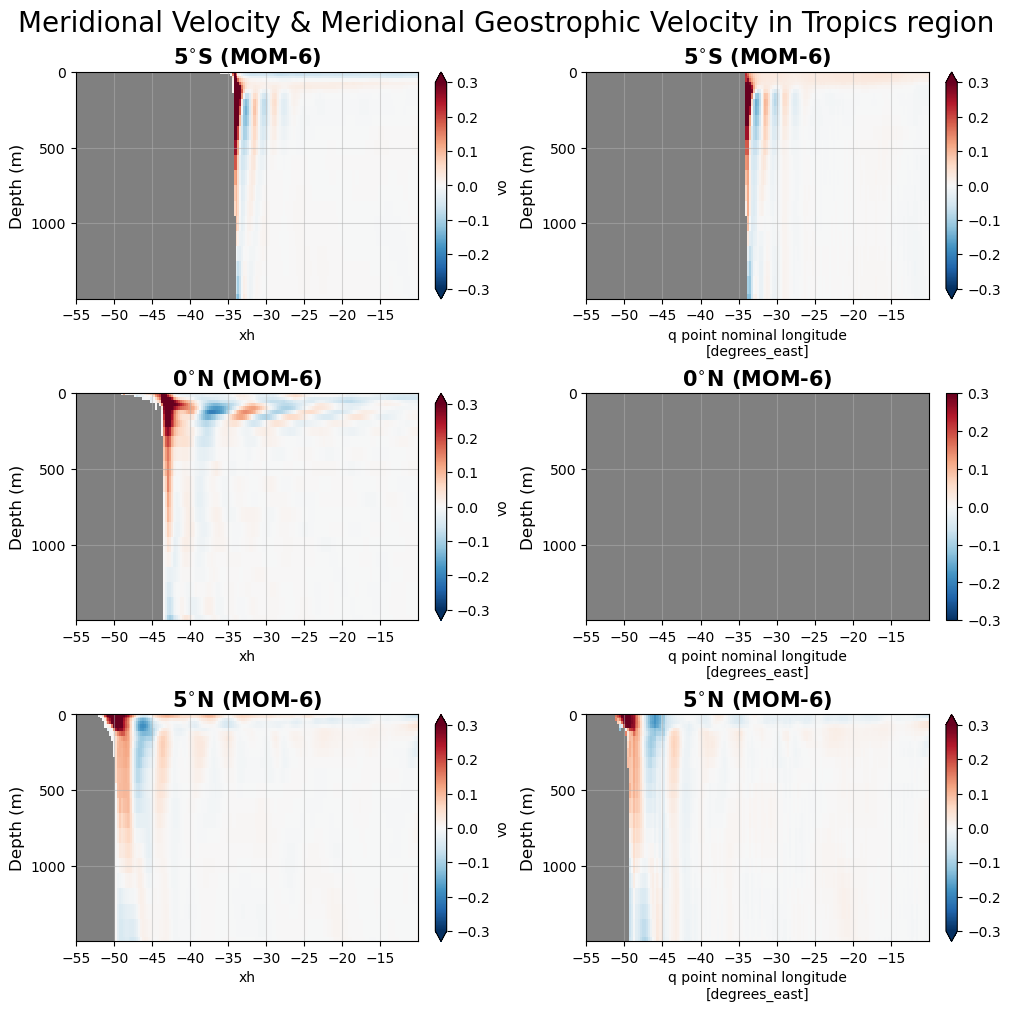

In [61]:
fig,ax=plt.subplots(nrows=3,ncols=2,constrained_layout=True,figsize=(10,10))

# velocity
v_5S=vo_mean.sel(yq=-5,method="nearest")#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))
v_5S.plot(ax=ax[0,0],x='xh',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

v_0=vo_mean.sel(yq=0,method="nearest")
v_0.plot(ax=ax[1,0],x='xh',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

v_5N=vo_mean.sel(yq=5,method="nearest")
v_5N.plot(ax=ax[2,0],x='xh',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)



for i in range(0,3):
    lat=str(int((5*i)-5))
    ax[i,0].set_facecolor('grey')
    ax[i,0].set_xlim(-55,-10)
    ax[i,0].set_ylabel('Depth (m)',fontsize=12)
    ax[i,0].set_ylim(0,1500)
    ax[i,0].set_title(lat +'$^{\circ}$N (MOM-6)',weight='bold',fontsize=15)
    ax[i,0].set_yticks(np.arange(0,1500,500))
    ax[i,0].set_xticks(np.arange(-55,-10,5))
    ax[i,0].grid(alpha=0.5)
    ax[i,0].invert_yaxis()
    
# velocity from geostrophic shear
vg_5S=velo_from_shear_v.sel(yh=-5,method="nearest")#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))
vg_5S.plot(ax=ax[0,1],x='xq',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

vg_0=velo_from_shear_v.sel(yh=0,method="nearest")
vg_0.plot(ax=ax[1,1],x='xq',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

vg_5N=velo_from_shear_v.sel(yh=5,method="nearest")
vg_5N.plot(ax=ax[2,1],x='xq',y='z_l',cmap='RdBu_r',vmin=-0.3,vmax=0.3)

for k in range(0,3):
    lat2=str(int((5*k)-5))
    ax[k,1].set_facecolor('grey')
    ax[k,1].set_xlim(-55,-10)
    ax[k,1].set_ylabel('Depth (m)',fontsize=12)
    ax[k,1].set_ylim(0,1500)
    ax[k,1].set_title(lat2 +'$^{\circ}$N (MOM-6)',weight='bold',fontsize=15)
    ax[k,1].set_yticks(np.arange(0,1500,500))
    ax[k,1].set_xticks(np.arange(-55,-10,5))
    ax[k,1].grid(alpha=0.5)
    ax[k,1].invert_yaxis()

ax[0,0].set_title('5$^{\circ}$S (MOM-6)',weight='bold',fontsize=15)
ax[0,1].set_title('5$^{\circ}$S (MOM-6)',weight='bold',fontsize=15)

fig.suptitle('Meridional Velocity & Meridional Geostrophic Velocity in Tropics region',fontsize=20)

In [46]:
# Geostrophic Shear at 5S, 0, 5N
'''
fig,ax=plt.subplots(nrows=4,ncols=1,constrained_layout=True,figsize=(10,15))

vg_5S=((vo_mean.sel(yq=-5,method="nearest"))*static.dxCv).sum('xh')#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))
vg_5S.sel(yq=-5,method='nearest').plot(ax=ax[0])

vg_0=((vo_mean.sel(yq=0,method="nearest"))*static.dxCv).sum('xh')
vg_0.sel(yq=0,method='nearest').plot(ax=ax[1])

vg_25=((vo_mean.sel(yq=2.5,method="nearest"))*static.dxCv).sum('xh')
vg_25.sel(yq=2.5,method='nearest').plot(ax=ax[2])

vg_5N=((vo_mean.sel(yq=5,method="nearest"))*static.dxCv).sum('xh')
vg_5N.sel(yq=5,method='nearest').plot(ax=ax[3])


ax[0].set_title('5 $^{\circ}$S (MOM-6)',weight='bold',fontsize=15)    
ax[1].set_title('$0^{\circ}$N(MOM-6)',weight='bold',fontsize=15)
ax[2].set_title('2.5$^{\circ}$N (MOM-6)',weight='bold',fontsize=15)
ax[3].set_title('5$^{\circ}$N (MOM-6)',weight='bold',fontsize=15)
fig.suptitle('Meridional Velocity in Tropics Region',fontsize=20)
'''

'\nfig,ax=plt.subplots(nrows=4,ncols=1,constrained_layout=True,figsize=(10,15))\n\nvg_5S=((vo_mean.sel(yq=-5,method="nearest"))*static.dxCv).sum(\'xh\')#.where((velo_from_shear.x > 3) | (velo_from_shear.yh < -3))\nvg_5S.sel(yq=-5,method=\'nearest\').plot(ax=ax[0])\n\nvg_0=((vo_mean.sel(yq=0,method="nearest"))*static.dxCv).sum(\'xh\')\nvg_0.sel(yq=0,method=\'nearest\').plot(ax=ax[1])\n\nvg_25=((vo_mean.sel(yq=2.5,method="nearest"))*static.dxCv).sum(\'xh\')\nvg_25.sel(yq=2.5,method=\'nearest\').plot(ax=ax[2])\n\nvg_5N=((vo_mean.sel(yq=5,method="nearest"))*static.dxCv).sum(\'xh\')\nvg_5N.sel(yq=5,method=\'nearest\').plot(ax=ax[3])\n\n\nax[0].set_title(\'5 $^{\\circ}$S (MOM-6)\',weight=\'bold\',fontsize=15)    \nax[1].set_title(\'$0^{\\circ}$N(MOM-6)\',weight=\'bold\',fontsize=15)\nax[2].set_title(\'2.5$^{\\circ}$N (MOM-6)\',weight=\'bold\',fontsize=15)\nax[3].set_title(\'5$^{\\circ}$N (MOM-6)\',weight=\'bold\',fontsize=15)\nfig.suptitle(\'Meridional Velocity in Tropics Region\',fontsize=2

# Calculation of Northward Meridional Volume Transport through the Equator in the Tropics of the Atlantic Basin
<a name="volume_plot"></a>

In [47]:
basin=xr.open_dataset('/vortex1/OM4_output/new_run/basin_codes.nc')

In [48]:
basin.basin.coords
basin_interp=grid.interp(basin.basin,axis='Y')

In [49]:
vo_mean_atl=vo_mean.where((basin_interp==2)|(basin_interp==17)).where((vo_mean.xh<-30)&(vo_mean.xh>-60))

Text(0.5, 1.0, 'Meridional Volume Transported in Tropics Region')

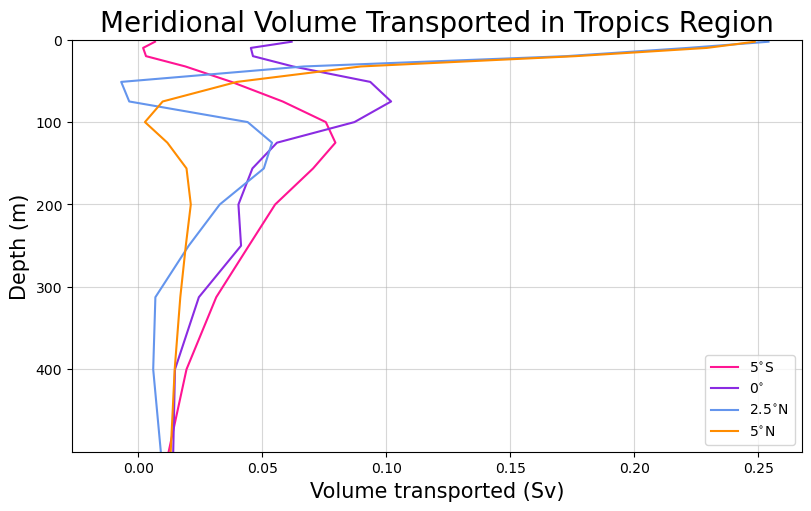

In [50]:
# range is (between -30 and -60)
fig,ax=plt.subplots(nrows=1,ncols=1,constrained_layout=True)

vg_5S=(((vo_mean_atl.sel(yq=-5,method="nearest"))*static.dxCv).sum('xh'))/10**6
vg_5S.sel(yq=-5,method='nearest').plot(y='z_l',label='5$^{\circ}$S',color='deeppink')

vg_0=(((vo_mean_atl.sel(yq=0,method="nearest"))*static.dxCv).sum('xh'))/10**6
vg_0.sel(yq=0,method='nearest').plot(y='z_l',label='0$^{\circ}$',color='blueviolet')

vg_25=(((vo_mean_atl.sel(yq=2.5,method="nearest"))*static.dxCv).sum('xh'))/10**6
vg_25.sel(yq=2.5,method='nearest').plot(y='z_l',label='2.5$^{\circ}$N',color='cornflowerblue')

vg_5N=(((vo_mean_atl.sel(yq=5,method="nearest"))*static.dxCv).sum('xh'))/10**6
vg_5N.sel(yq=5,method='nearest').plot(y='z_l',label='5$^{\circ}$N',color='darkorange')


ax.set_ylim(0,500)
ax.set_yticks(np.arange(0,500,100))
ax.invert_yaxis()
ax.grid(alpha=0.5)
ax.set_ylabel('Depth (m)',fontsize=15)
ax.set_xlabel('Volume transported (Sv)',fontsize=15)
ax.legend()
ax.set_title('Meridional Volume Transported in Tropics Region',fontsize=20)

## Plots of geostrophic $u_g$ velocity calculated from geostrophic shear
<a name="geouvelo"></a>

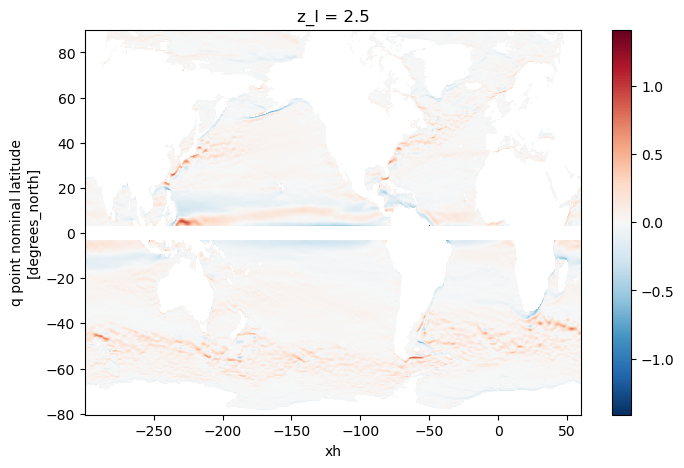

In [56]:
c=velo_from_shear_u.isel(z_l=0).where((velo_from_shear_u.yq > 3) | (velo_from_shear_u.yq < -3))
c.plot(cmap='RdBu_r')#,vmin=-1,vmax=1)